## Multivariate Regression 

* We are going to focus on multivariate Linear Regression as a problem space to discuss **regularization** and **dimensionality reduction**. 
* The concepts discussed here will be extend to classification problems, by integrating Logistic Regression integrated into the discussion when appropriate.  

### Matrix Representation of the Multivariate Regression Model 

$$ \boldsymbol{Y} = \boldsymbol{X \beta} + \boldsymbol{\epsilon}$$


* $\boldsymbol{X}$ is an n $\times$ (M+1) matrix
* $\boldsymbol{\beta}$ is an M+1-dimensional vector 
* $\boldsymbol{Y}$ is an n-dimensional vector 
* $\boldsymbol{\epsilon}$ is an n-dimensional vector
* where n is the number of data points and M is the number of predictors

$$
\boldsymbol{Y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}, \quad \boldsymbol{X} = \begin{bmatrix}
1 & x_{1,1} & x_{1,2} & \dots & x_{1,M} \\
1 & x_{2,1} & x_{2,2} & \dots & x_{2,M} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{n,1} & x_{n,2} & \dots & x_{n,M} \\
\end{bmatrix}, \quad \beta = \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_M
\end{bmatrix}, \quad \boldsymbol{\epsilon} = \begin{bmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n
\end{bmatrix}
$$



### Ordinary Least-Squares Solution 

$$ MSE(\boldsymbol{\beta}) = \frac{1}{n} \Vert \boldsymbol{Y} - \boldsymbol{X \beta} \Vert  $$

$$ \hat{\boldsymbol{\beta}} = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{Y} $$

In [1]:
# Data and Stats packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### EDA: House Price Data From Kaggle

House price dataset is taken from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction). 

The task is to build a regression model to **predict the price**, based on different attributes.

To make this run quicker, we're going to draw a random subset of 4000 random samples and 9 predictors.  

In [2]:
# Load the dataset 
house_df = pd.read_csv('../data/kc_house_data.csv')
#this line grabs a random subset of 4000
house_df = house_df.sample(frac=1, random_state=42)[0:4000]
#I am choosing these 9 predictors 
cols_of_interest = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above',
                    'lat', 'long', 'price']
house_df = house_df[cols_of_interest]
#lets convert price to $1000's, "K"
house_df['price'] = house_df['price']/1000
print(house_df.shape)
print(house_df.dtypes)
house_df.head()

(4000, 9)
bedrooms         int64
bathrooms      float64
sqft_living      int64
sqft_lot         int64
floors         float64
sqft_above       int64
lat            float64
long           float64
price          float64
dtype: object


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long,price
735,4,2.25,2070,8893,2.0,2070,47.4388,-122.162,365.0
2830,5,3.00,2900,6730,1.0,1830,47.6784,-122.285,865.0
4106,4,2.50,3770,10893,2.0,3770,47.5646,-122.129,1038.0
16218,3,3.50,4560,14608,2.0,4560,47.6995,-122.228,1490.0
19964,3,2.50,2550,5376,2.0,2550,47.6647,-122.083,711.0


Now let's check for null values and look at the datatypes within the dataset.

In [3]:
house_df.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long,price
count,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,3.379250,2.116563,2096.645250,1.616511e+04,1.475000,1792.465000,47.560091,-122.214060,549.75221
std,0.922568,0.783175,957.785141,5.120888e+04,0.530279,849.986192,0.139070,0.141879,389.05053
min,0.000000,0.000000,384.000000,5.720000e+02,1.000000,384.000000,47.155900,-122.515000,82.50000
25%,3.000000,1.750000,1420.000000,5.200000e+03,1.000000,1180.000000,47.468175,-122.328000,324.95000
50%,3.000000,2.250000,1920.000000,7.675000e+03,1.000000,1550.000000,47.573800,-122.231000,455.00000
75%,4.000000,2.500000,2570.000000,1.087125e+04,2.000000,2250.000000,47.679100,-122.127000,654.12500
max,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,47.777500,-121.315000,5570.00000


Let's see how the response variable (`price`) is distributed

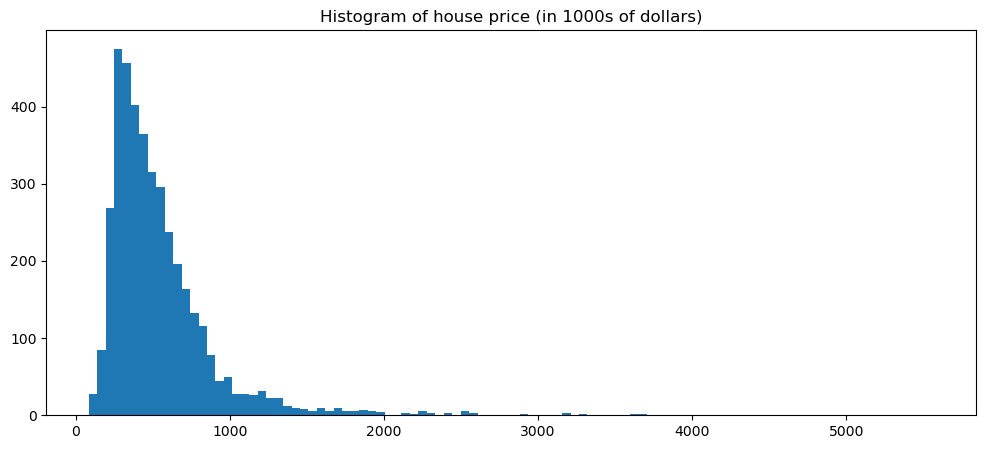

In [4]:
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(house_df['price'], bins=100)
ax.set_title('Histogram of house price (in 1000s of dollars)');

I somewhat dislike this.  Consider this alternative, which may produce a better model. 

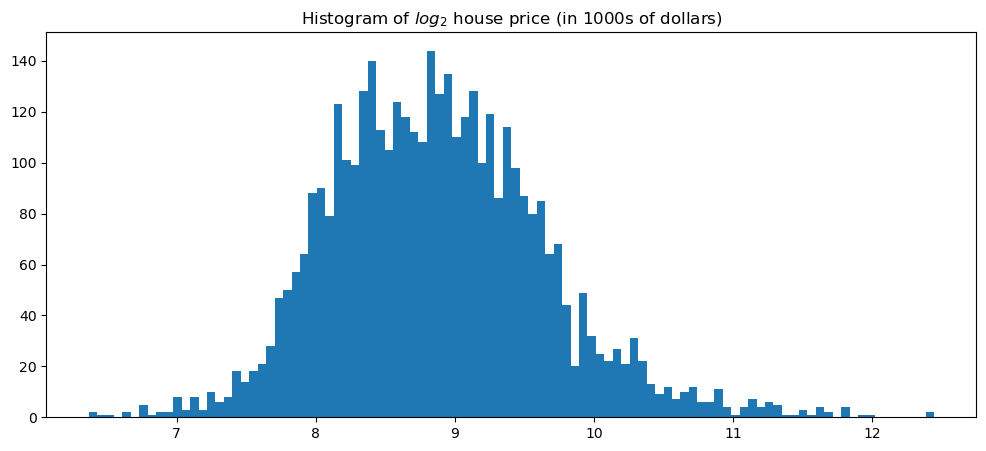

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(np.log2(house_df['price']), bins=100)
ax.set_title('Histogram of $log_2$ house price (in 1000s of dollars)');

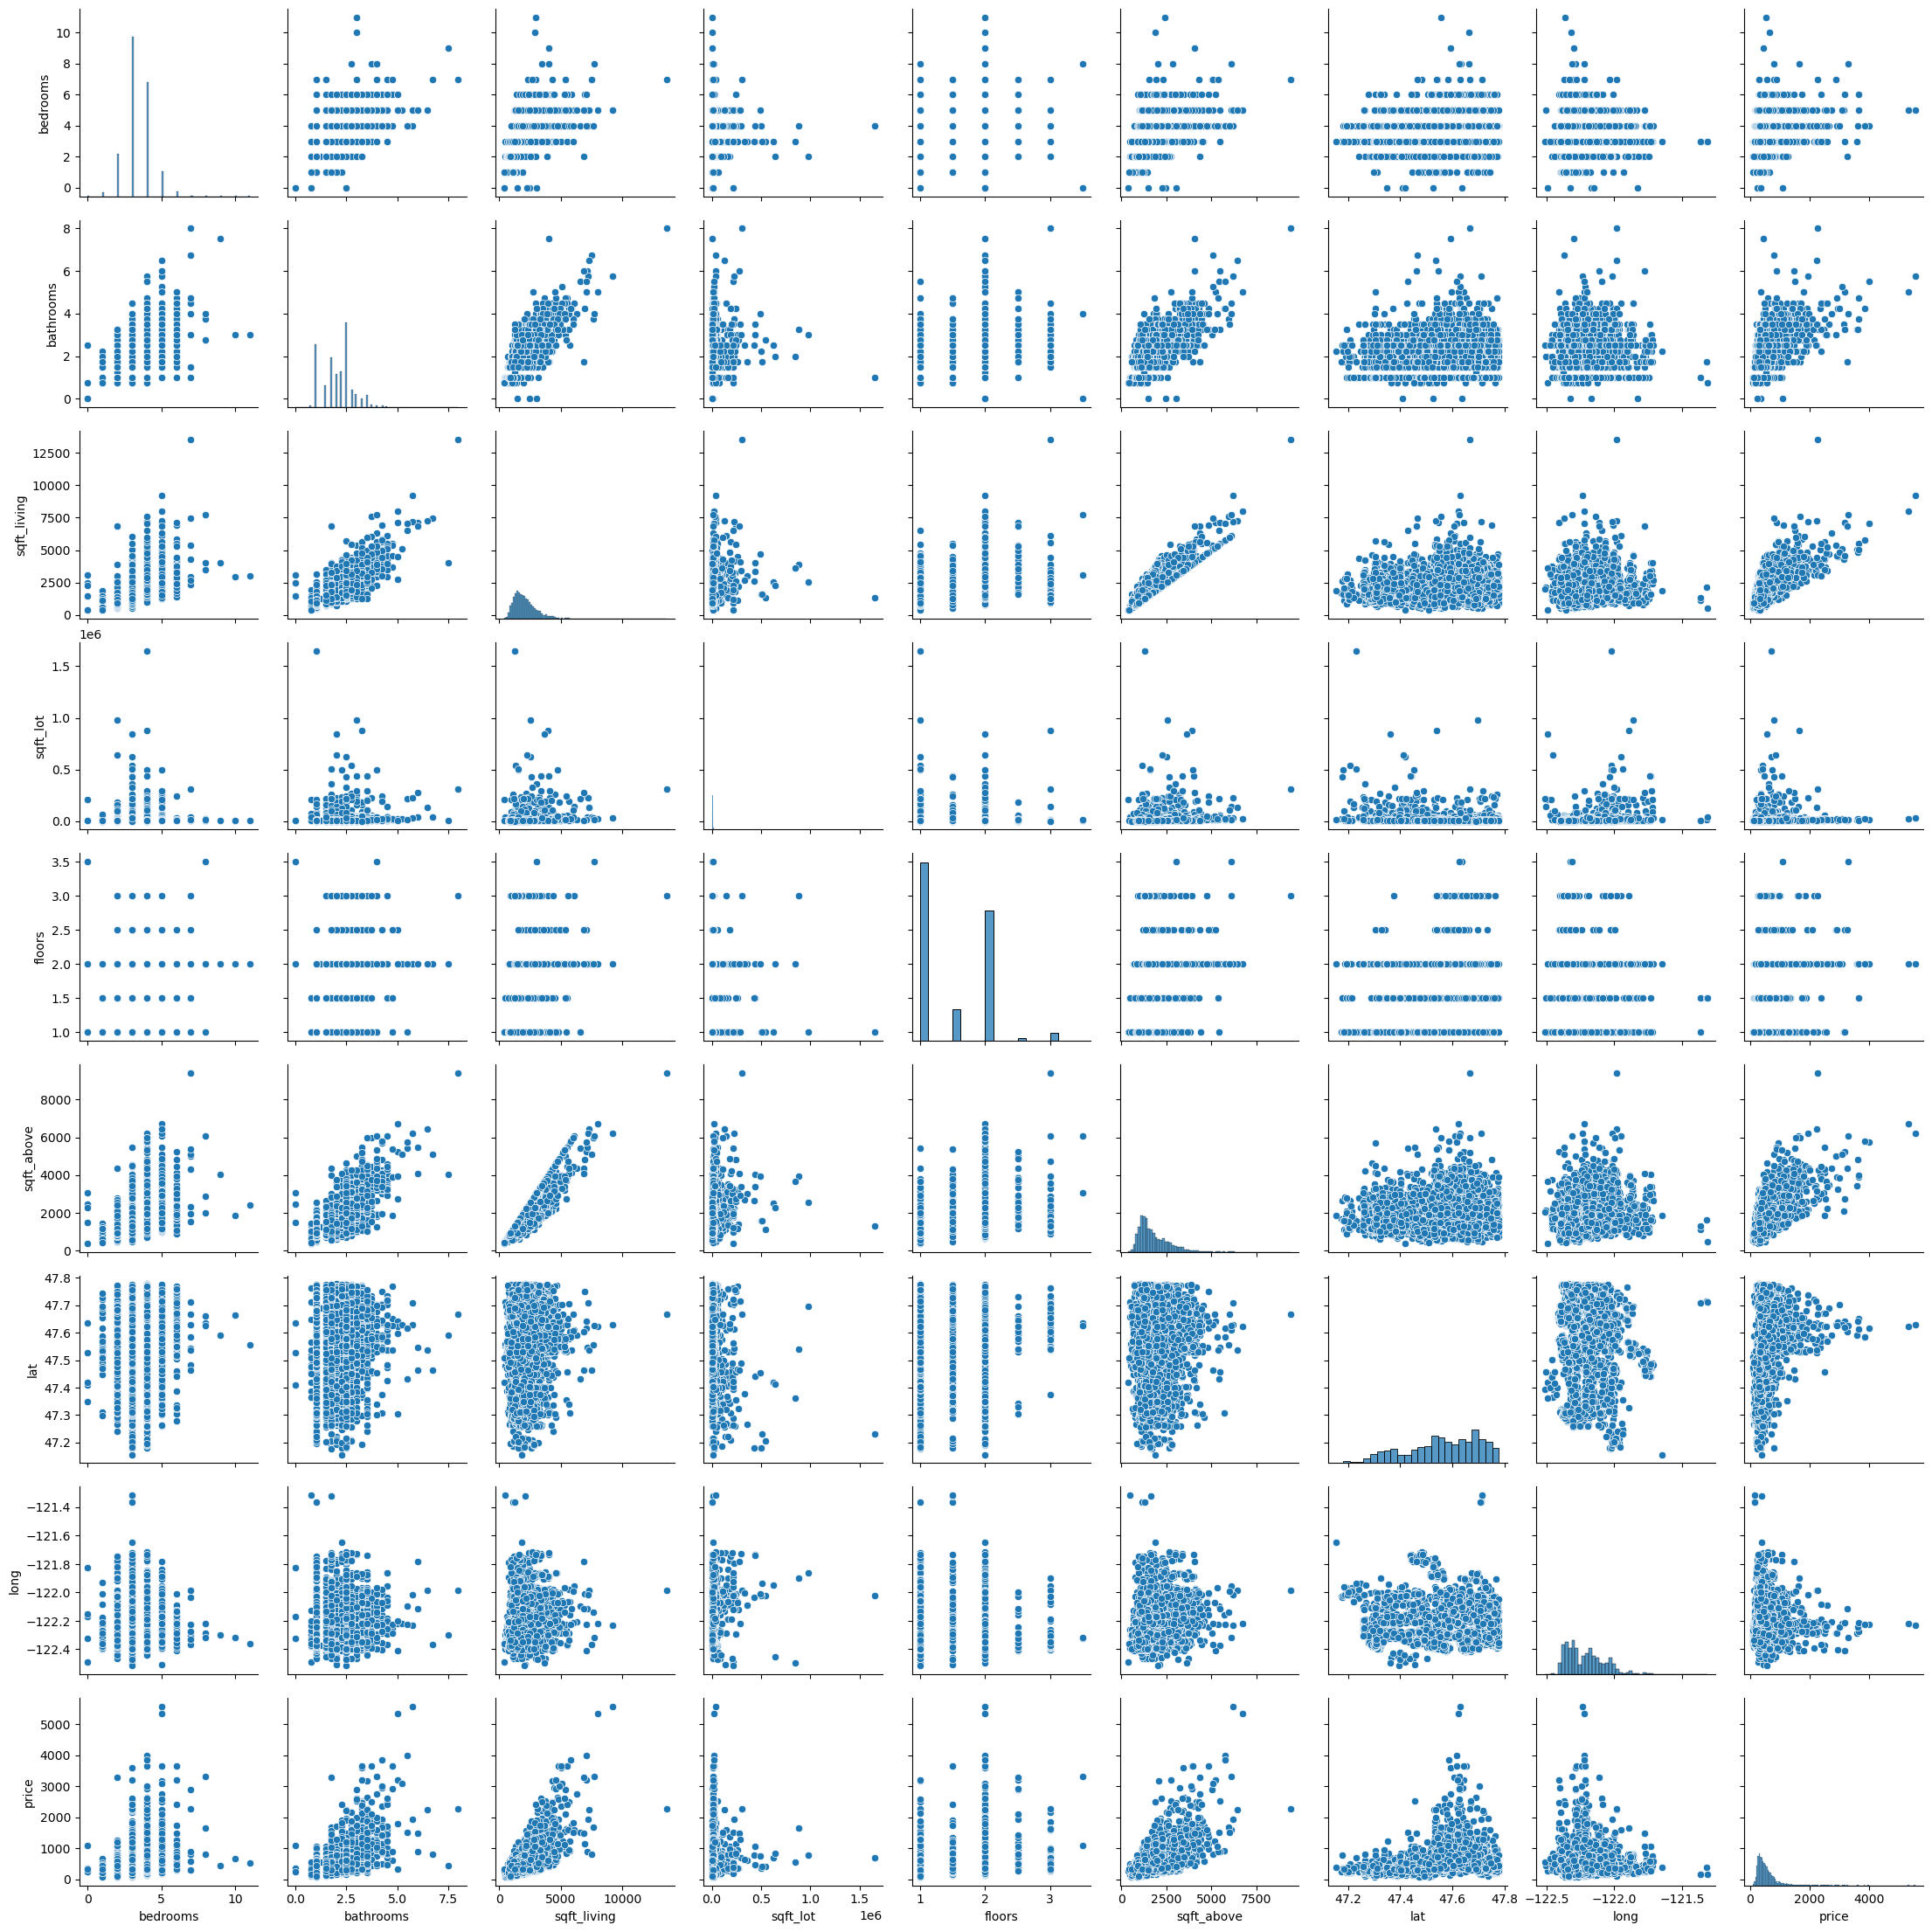

In [6]:
sns.pairplot(house_df);

<Axes: >

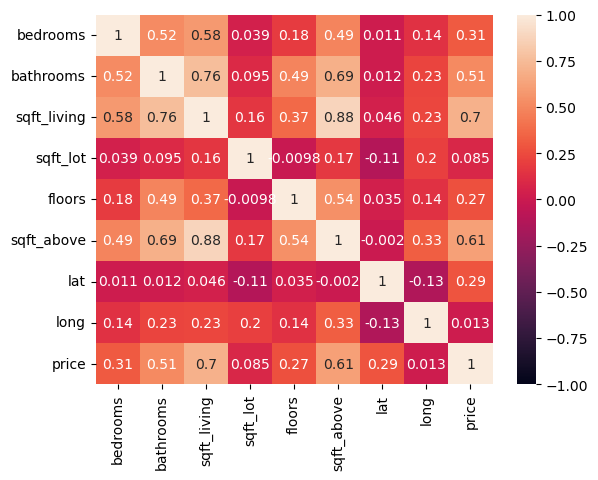

In [7]:
sns.heatmap(house_df.corr(), vmin=-1, vmax=1, annot=True)

## Train-Validation-Test Split

This is the general idea: 

1. **Training Set**: Data you have seen. You train different types of models with various different hyper-parameters (i.e., parameters of your modeling pipeline) on this data. 


2. **Validation Set**: Used to compare different models predictive abilities. We use this step to tune our hyper-parameters i.e. find the optimal set of hyper-parameters (such as $k$ for k-NN or our $\beta_i$ values or number of degrees of our polynomial for linear regression). Pick your best model here. 



3. **Test Set**: Using the best model from the previous step, simply report the score e.g. R^2 score, MSE or any metric that you care about, of that model on your test set. **DON'T TUNE YOUR PARAMETERS HERE!**. Why, I hear you ask? Because we want to know how our model might do on data it hasn't seen before. We don't have access to this data (because it may not exist yet) but the test set, which we haven't seen or touched so far, is a good way to mimic this new data. 

Let's do 60% train, 20% validation, 20% test for this dataset.

In [8]:
from sklearn.model_selection import train_test_split

# first split the data into a train-test split and don't touch the test set yet
train_df, test_df = train_test_split(house_df, test_size=0.2, random_state=42)

# next, split the training set into a train-validation split
# the test-size is 0.25 since we are splitting 80% of the data into 20% and 60% overall
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)


### Standardization 
In the Linear Regression model after standardization 
* the intercept term is interpreted as the expected value of 𝑌𝑖 when the predictor values are set to their means.
* Without standardization, the intercept is interpreted as the expected value of $Y$ when $boldsymbol{X}$ = 0. 

In [9]:
from sklearn.preprocessing import StandardScaler

features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above',
            'lat', 'long']

X_train = train_df[features]
y_train = np.array(train_df['price']).reshape(-1,1)

X_val = val_df[features]
y_val = np.array(val_df['price']).reshape(-1,1)

X_test = test_df[features]
y_test = np.array(test_df['price']).reshape(-1,1)

scaler = StandardScaler().fit(X_train)

# This converts our matrices into numpy matrices
X_train_t = scaler.transform(X_train)
X_val_t = scaler.transform(X_val)
X_test_t = scaler.transform(X_test)

# Making the numpy matrices pandas dataframes
X_train_df = pd.DataFrame(X_train_t, columns=features)
X_val_df = pd.DataFrame(X_val_t, columns=features)
X_test_df = pd.DataFrame(X_test_t, columns=features)

display(X_train_df.describe())
display(X_val_df.describe())
display(X_test_df.describe())

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long
count,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03
mean,2.102022e-16,1.361874e-16,1.332268e-16,-2.294461e-17,1.998401e-17,-1.480297e-18,4.931463e-14,4.769074e-14
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-3.618993e+00,-2.677207e+00,-1.766429e+00,-3.364203e-01,-8.897850e-01,-1.636285e+00,-2.937091e+00,-2.084576e+00
25%,-4.009185e-01,-4.598398e-01,-7.087691e-01,-2.324570e-01,-8.897850e-01,-7.089826e-01,-6.732889e-01,-8.086270e-01
50%,-4.009185e-01,1.736938e-01,-1.933403e-01,-1.774091e-01,-8.897850e-01,-2.895998e-01,8.468878e-02,-1.278830e-01
75%,6.717731e-01,4.904606e-01,4.973342e-01,-1.033061e-01,9.975186e-01,5.375162e-01,8.607566e-01,6.455277e-01
max,7.107923e+00,7.459330e+00,1.179553e+01,1.945618e+01,3.828474e+00,8.878574e+00,1.560846e+00,6.062967e+00


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.018772,0.041444,0.024401,0.016506,0.026737,0.044415,-0.056059,0.016900
std,0.982683,0.997594,0.989079,1.074079,0.991645,0.993807,1.008010,1.028649
min,-2.546302,-1.726907,-1.626232,-0.328715,-0.889785,-1.477851,-2.693960,-2.141602
25%,-0.400918,-0.459840,-0.677843,-0.234254,-0.889785,-0.685684,-0.737509,-0.815755
50%,-0.400918,0.173694,-0.172723,-0.177521,0.053867,-0.266301,0.031504,-0.088678
75%,0.671773,0.490461,0.487026,-0.113533,0.997519,0.595764,0.817340,0.597412
max,8.180614,4.925195,7.321611,21.716593,2.884822,5.139078,1.554333,6.369480


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.010727,-0.018346,-0.029080,0.052808,0.006684,-0.021866,-0.005631,0.000897
std,0.965422,0.963162,0.946367,1.569619,1.012587,0.955805,1.022830,1.028155
min,-3.618993,-2.677207,-1.657158,-0.335005,-0.889785,-1.524449,-2.656332,-1.778063
25%,-0.400918,-0.459840,-0.701038,-0.229160,-0.889785,-0.708983,-0.624084,-0.789024
50%,-0.400918,0.173694,-0.183032,-0.174051,-0.889785,-0.295425,0.174054,-0.174216
75%,0.671773,0.490461,0.417443,-0.100683,0.997519,0.479269,0.842124,0.604540
max,4.962540,3.658128,5.785633,36.746809,3.828474,5.010933,1.544926,6.412249


In [10]:
scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

### Fit the Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression 
lr = LinearRegression()
lr.fit(X_train_df,y_train)
y_predict = lr.predict(X_val_df)
r2_train = lr.score(X_train_df,y_train)
print('Training r^2',r2_train)
r2_val = lr.score(X_val_df,y_val)
print('Validation r^2', r2_val)

Training r^2 0.5855548581833068
Validation r^2 0.591188056362016


## Two-Degree Polynomial Model

In [12]:
def add_square_terms(df):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        df['{}^2'.format(col)] = df[col]**2
    return df

X_train_df_2 = add_square_terms(X_train)
X_val_df_2 = add_square_terms(X_val)

# Standardizing our added coefficients
cols = X_train_df_2.columns
scaler = StandardScaler().fit(X_train_df_2)
X_train_df_2 = pd.DataFrame(scaler.transform(X_train_df_2), columns=cols)
X_val_df_2 = pd.DataFrame(scaler.transform(X_val_df_2), columns=cols)

print(X_train_df.shape, X_train_df_2.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_2.head()

(2400, 8) (2400, 16)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long,bedrooms^2,bathrooms^2,sqft_living^2,sqft_lot^2,floors^2,sqft_above^2,lat^2,long^2
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.261919,-1.179294,-0.462425,-0.498149,-0.435619,-0.081332,-0.820725,-0.317640,-0.263451,1.180094
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,0.525365,0.289117,-0.462425,0.962623,0.551247,-0.079773,0.882097,1.104202,0.524670,-0.289785
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,0.720739,0.545733,0.533184,0.286055,-0.174327,-0.080898,-0.820725,-0.625213,0.720531,-0.546402
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,0.066599,-0.088678,-0.462425,0.286055,-0.217531,-0.076044,-0.820725,-0.003426,0.065197,0.088151
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,-1.411729,0.232092,-0.462425,0.286055,-0.332701,-0.081403,-0.820725,-0.436000,-1.411246,-0.232748


In [13]:
lr2 = LinearRegression()
lr2.fit(X_train_df_2,y_train)
y_predict = lr2.predict(X_val_df_2)
r2_train_2 = lr2.score(X_train_df_2,y_train)
print(r2_train_2)
r2_val_2 = lr2.score(X_val_df_2,y_val)
print(r2_val_2)

0.6070215448868861
0.5891234394036486


## Three-Degree Polynomial Model

In [14]:
# generalizing our function from above
def add_square_and_cube_terms(df):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        df['{}^2'.format(col)] = df[col]**2
        df['{}^3'.format(col)] = df[col]**3
    return df

X_train_df_3 = add_square_and_cube_terms(X_train)
X_val_df_3 = add_square_and_cube_terms(X_val)

# Standardizing our added coefficients
cols = X_train_df_3.columns
scaler = StandardScaler().fit(X_train_df_3)
X_train_df_3 = pd.DataFrame(scaler.transform(X_train_df_3), columns=cols)
X_val_df_3 = pd.DataFrame(scaler.transform(X_val_df_3), columns=cols)

print(X_train_df.shape, X_train_df_3.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_3.head()

(2400, 8) (2400, 24)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long,bedrooms^2,bedrooms^3,...,sqft_lot^2,sqft_lot^3,floors^2,floors^3,sqft_above^2,sqft_above^3,lat^2,lat^3,long^2,long^3
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.261919,-1.179294,-0.462425,-0.433878,...,-0.081332,-0.052800,-0.820725,-0.716812,-0.317640,-0.259891,-0.263451,-0.264982,1.180094,-1.180893
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,0.525365,0.289117,-0.462425,-0.433878,...,-0.079773,-0.052774,0.882097,0.708772,1.104202,0.616150,0.524670,0.523971,-0.289785,0.290452
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,0.720739,0.545733,0.533184,0.342544,...,-0.080898,-0.052793,-0.820725,-0.716812,-0.625213,-0.367027,0.720531,0.720318,-0.546402,0.547071
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,0.066599,-0.088678,-0.462425,-0.433878,...,-0.076044,-0.052686,-0.820725,-0.716812,-0.003426,-0.113103,0.065197,0.063793,0.088151,-0.087625
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,-1.411729,0.232092,-0.462425,-0.433878,...,-0.081403,-0.052801,-0.820725,-0.716812,-0.436000,-0.306038,-1.411246,-1.410757,-0.232748,0.233404


In [15]:
lr3 = LinearRegression()
lr3.fit(X_train_df_3,y_train)
y_predict = lr3.predict(X_val_df_3)
r2_train_3 = lr3.score(X_train_df_3,y_train)
print(r2_train_3)
r2_val_3 = lr3.score(X_val_df_3,y_val)
print(r2_val_3)

0.6956554694496888
0.6474653306583327


## N-Degree Polynomial Model

In [16]:
# generalizing our function from above
def add_higher_order_polynomial_terms(df, N=7):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        for i in range(2, N+1):
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

N = 4
X_train_df_N = add_higher_order_polynomial_terms(X_train,N)
X_val_df_N = add_higher_order_polynomial_terms(X_val,N)

# Standardizing our added coefficients
cols = X_train_df_N.columns
scaler = StandardScaler().fit(X_train_df_N)
X_train_df_N = pd.DataFrame(scaler.transform(X_train_df_N), columns=cols)
X_val_df_N = pd.DataFrame(scaler.transform(X_val_df_N), columns=cols)

print(X_train_df.shape, X_train_df_N.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_N.head()

(2400, 8) (2400, 32)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long,bedrooms^2,bedrooms^3,...,floors^4,sqft_above^2,sqft_above^3,sqft_above^4,lat^2,lat^3,lat^4,long^2,long^3,long^4
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.261919,-1.179294,-0.462425,-0.433878,...,-0.591427,-0.317640,-0.259891,-0.157166,-0.263451,-0.264982,-0.266511,1.180094,-1.180893,1.181692
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,0.525365,0.289117,-0.462425,-0.433878,...,0.505638,1.104202,0.616150,0.231521,0.524670,0.523971,0.523268,-0.289785,0.290452,-0.291118
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,0.720739,0.545733,0.533184,0.342544,...,-0.591427,-0.625213,-0.367027,-0.183625,0.720531,0.720318,0.720101,-0.546402,0.547071,-0.547739
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,0.066599,-0.088678,-0.462425,-0.433878,...,-0.591427,-0.003426,-0.113103,-0.108971,0.065197,0.063793,0.062389,0.088151,-0.087625,0.087098
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,-1.411729,0.232092,-0.462425,-0.433878,...,-0.591427,-0.436000,-0.306038,-0.169774,-1.411246,-1.410757,-1.410261,-0.232748,0.233404,-0.234061


In [17]:
lrN = LinearRegression()
lrN.fit(X_train_df_N,y_train)
y_predict = lrN.predict(X_val_df_N)
r2_train = lrN.score(X_train_df_N,y_train)
print(r2_train)
r2_test = lrN.score(X_val_df_N,y_val)
print(r2_test)

0.703698644048494
0.652481597275474


In [18]:
train_score = list()
val_score = list()
train_score.append(r2_train)
val_score.append(r2_val)
for n in range(2,9):
    N = n
    X_train_df_N = add_higher_order_polynomial_terms(X_train,N)
    X_val_df_N = add_higher_order_polynomial_terms(X_val,N)

# Standardizing our added coefficients
    cols = X_train_df_N.columns
    scaler = StandardScaler().fit(X_train_df_N)
    X_train_df_N = pd.DataFrame(scaler.transform(X_train_df_N), columns=cols)
    X_val_df_N = pd.DataFrame(scaler.transform(X_val_df_N), columns=cols)
    lrN = LinearRegression()
    lrN.fit(X_train_df_N,y_train)
    y_predict = lrN.predict(X_val_df_N)
    r2_train_N = lrN.score(X_train_df_N,y_train)
    train_score.append(r2_train_N)
    r2_val_N = lrN.score(X_val_df_N,y_val)
    val_score.append(r2_val_N)

Text(0, 0.5, '$r^2$')

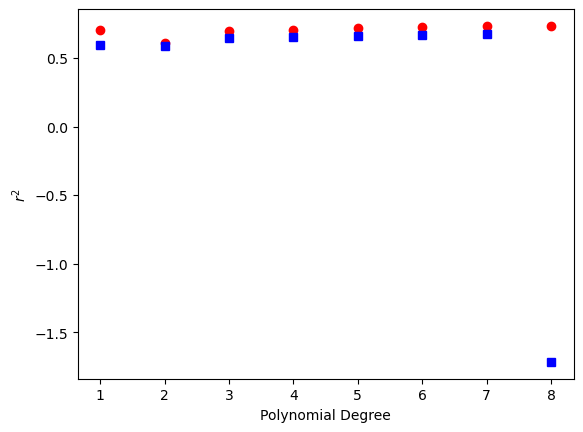

In [19]:
plt.plot(range(1,9),train_score,'ro',label = 'train')
plt.plot(range(1,9),val_score,'bs',label = 'val')
plt.xlabel('Polynomial Degree')
plt.ylabel('$r^2$')


* A big difference between training and validation R^2 scores is usually a sign that we are **overfitting**.



<img src="../images/bias_variance.png" width="600">

<img src="../images/overfit.png" width="600"> \\

## Model Selection and Cross-Validation

Here's our current setup so far: 

<img src="../images/train_val_test.png" width="400">

**we could also be overfitting the validation set!** 

One solution to the problems raised by using a single validation set is to evaluate each model on multiple validation sets and average the validation performance. This is the essence of cross-validation!

<img src="../images/cross_val.png" width="700">


### The problem of correlation among predictors 

Referred in the jargony world of statistics as **colinearity** or **multicolinearity** 

* Simulation of a bivariate regression model.  

In [20]:
b_true = np.array([3,7]).reshape((-1,1))
N=100
sigma = 5
X = np.random.normal(scale = 5, size = (N,2))
eps = np.random.normal(scale=sigma, size = (N,1))
y = X@b_true + eps
print(np.corrcoef(np.transpose(X)))

[[1.         0.04247115]
 [0.04247115 1.        ]]


In [21]:
lr = LinearRegression()
lr.fit(X,y)
print(lr.coef_)

[[3.0481704  7.12979797]]


In [22]:
b_true = np.array([3,7]).reshape((2,1))
# Generate random data with high colinearity between predictors
x1 = np.random.normal(scale = 5, size=(N,1))
x2 = x1 + np.random.normal(scale=0.2, size=(N,1))
X_colin = np.column_stack((x1,x2))
eps = np.random.normal(scale=sigma, size = (N,1))
y_colin = X_colin@b_true+eps
print(np.corrcoef(np.transpose(X_colin)))


[[1.         0.99940562]
 [0.99940562 1.        ]]


In [23]:
lr = LinearRegression()
lr.fit(X_colin,y_colin)
print(lr.coef_)

[[2.8458792  7.02837096]]


RIDGE REGRESSION

Lets revisit our poorly functioning over specified model with 8 degree polynomial in each of 8 predictors

In [24]:
# generalizing our function from above
def add_higher_order_polynomial_terms(df, N=7):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        for i in range(2, N+1):
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

N = 8
X_train_df_N = add_higher_order_polynomial_terms(X_train,N)
X_val_df_N = add_higher_order_polynomial_terms(X_val,N)

# Standardizing our added coefficients
cols = X_train_df_N.columns
scaler = StandardScaler().fit(X_train_df_N)
X_train_df_N = pd.DataFrame(scaler.transform(X_train_df_N), columns=cols)
X_val_df_N = pd.DataFrame(scaler.transform(X_val_df_N), columns=cols)

print(X_train_df.shape, X_train_df_N.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_N.head()

(2400, 8) (2400, 64)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long,bedrooms^2,bedrooms^3,...,lat^6,lat^7,lat^8,long^2,long^3,long^4,long^5,long^6,long^7,long^8
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.261919,-1.179294,-0.462425,-0.433878,...,-0.269565,-0.271089,-0.272612,1.180094,-1.180893,1.181692,-1.182490,1.183286,-1.184082,1.184877
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,0.525365,0.289117,-0.462425,-0.433878,...,0.521851,0.521137,0.520419,-0.289785,0.290452,-0.291118,0.291784,-0.292450,0.293116,-0.293781
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,0.720739,0.545733,0.533184,0.342544,...,0.719655,0.719425,0.719191,-0.546402,0.547071,-0.547739,0.548406,-0.549072,0.549737,-0.550401
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,0.066599,-0.088678,-0.462425,-0.433878,...,0.059577,0.058170,0.056761,0.088151,-0.087625,0.087098,-0.086570,0.086042,-0.085514,0.084986
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,-1.411729,0.232092,-0.462425,-0.433878,...,-1.409249,-1.408733,-1.408211,-0.232748,0.233404,-0.234061,0.234716,-0.235372,0.236027,-0.236682


First lets make a usual regression model 

In [26]:
lrN = LinearRegression()
lrN.fit(X_train_df_N,y_train)
y_predict = lrN.predict(X_val_df_N)
r2_train = lrN.score(X_train_df_N,y_train)
print(r2_train)
r2_val = lrN.score(X_val_df_N,y_val)
print(r2_val)

0.7336183244272214
-1.7170077191437683


OLS model: -1.7170077191437683
Ridge model: 0.6025912797654089


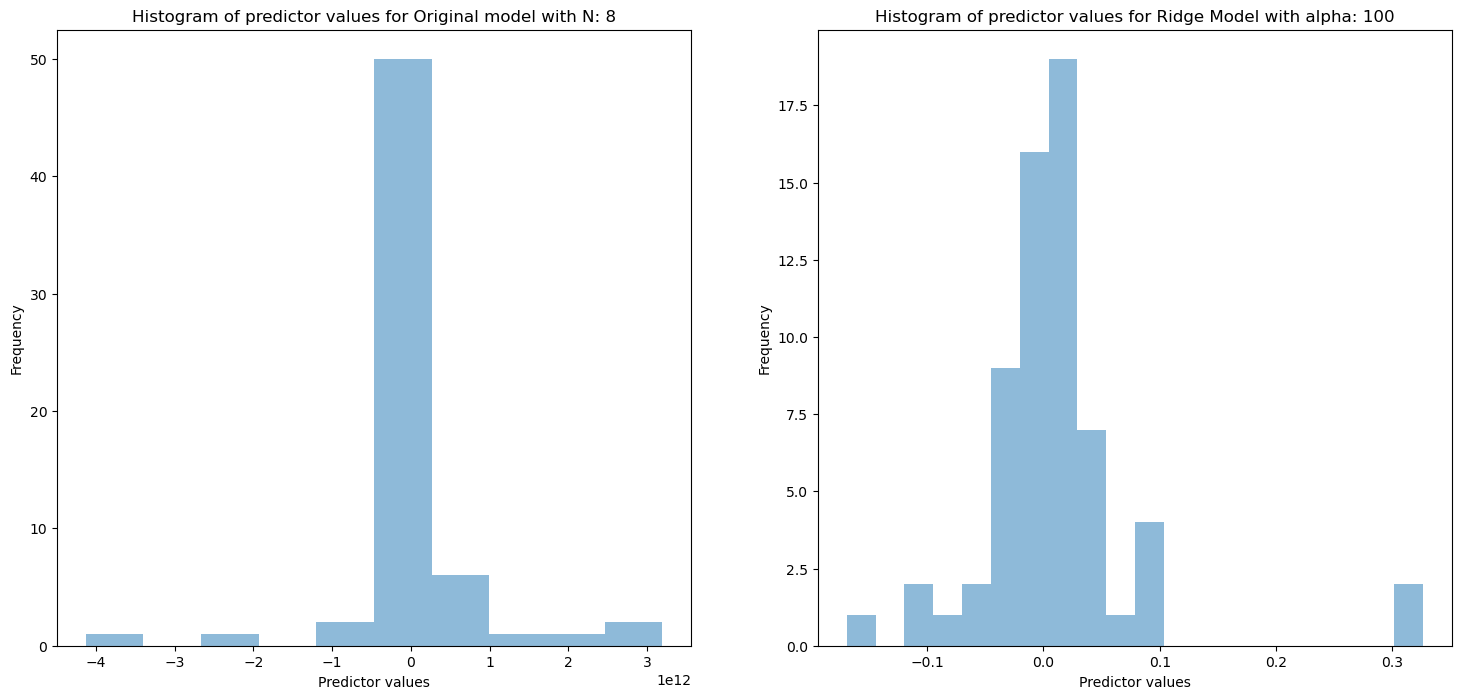

In [27]:
from sklearn.linear_model import Ridge

# some values you can try out: 0.01, 0.1, 0.5, 1, 5, 10, 20, 40, 100, 200, 500, 1000, 10000
alpha = 100
ridge_model = Ridge(alpha=alpha).fit(X_train_df_N, y_train)
ridge_val = ridge_model.score(X_val_df_N,y_val)
print('OLS model:',  r2_val)
print('Ridge model:', ridge_val)

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(lrN.coef_.flatten(), bins=10, alpha=0.5)
ax[0].set_title('OLS model')
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(ridge_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Ridge model')
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

LASSO

OLS model: -1.7170077191437683
Ridge model: 0.6025912797654089
LASSO model: 0.6119974891402222


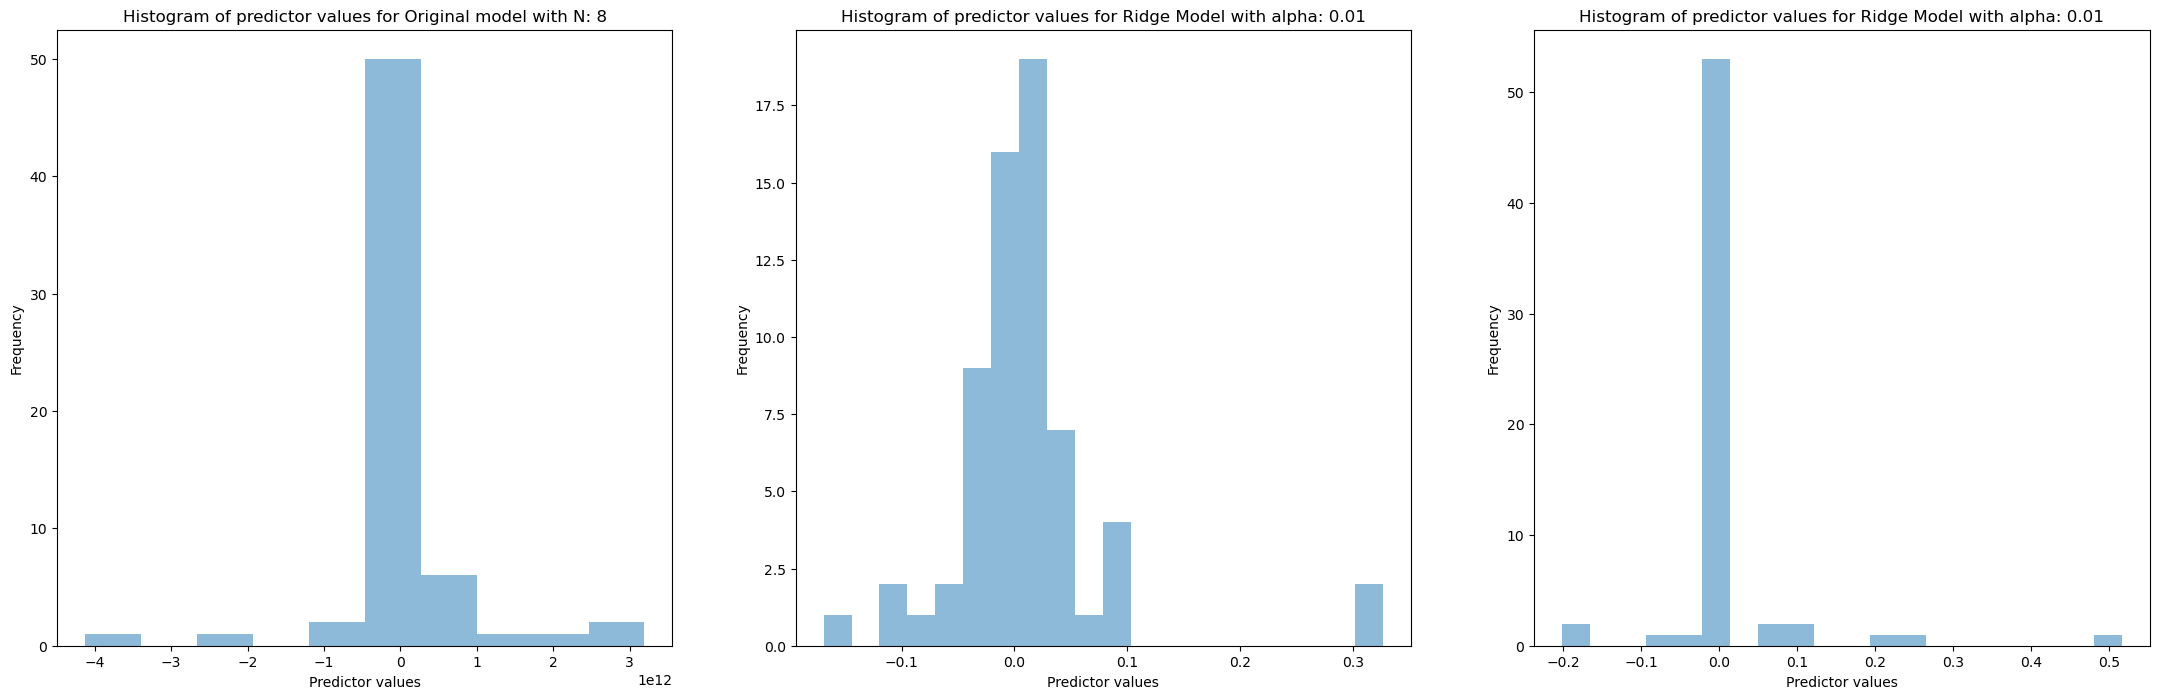

In [28]:
from sklearn.linear_model import Lasso

# some values you can try out: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20
alpha = 0.01
lasso_model = Lasso(alpha=alpha, max_iter = 1000).fit(X_train_df_N, y_train)
lasso_val = lasso_model.score(X_val_df_N,y_val)
print('OLS model:',  r2_val)
print('Ridge model:', ridge_val)
print('LASSO model:', lasso_val)
fig, ax = plt.subplots(figsize=(27,8), ncols=3)
ax = ax.ravel()
ax[0].hist(lrN.coef_.flatten(), bins=10, alpha=0.5)
ax[0].set_title('OLS model')
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(ridge_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Ridge Model')
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');
ax[2].hist(lasso_model.coef_.flatten(), bins=20, alpha=0.5)
ax[2].set_title('Lasso Model')
ax[2].set_xlabel('Predictor values')
ax[2].set_ylabel('Frequency');